# RNN Based molucule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model

Word-based models capture meaning at the word level. Capable of understanding and generating coherent sentences. Used for word semantics.
On the other hand, character-based models capture meaning at the character level. Capable of modeling text charcater by character. Smaller vocabulary used.

## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

Import pandas and load the first 1000 lines

In [3]:
import pandas as pd

df = pd.read_csv('data/250k_smiles.csv')

Display the first rows of the dataframe

In [4]:
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [14]:
max_len = max(df['smiles'].apply(len))
max_len

110


Code a function **unic_characters(string)** which return the unic characters in a string


In [20]:
def unic_characters(string):
    return set(string)

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [21]:
all_atoms = unic_characters(''.join(df['smiles']))
all_atoms

{'\n',
 '#',
 '(',
 ')',
 '+',
 '-',
 '/',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '=',
 '@',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'P',
 'S',
 '[',
 '\\',
 ']',
 'c',
 'l',
 'n',
 'o',
 'r',
 's'}

Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


In [22]:
def map_char_to_int(unic_chars):
    return {char: i for i, char in enumerate(unic_chars)}

char_to_int = map_char_to_int(all_atoms)
char_to_int

{'(': 0,
 '#': 1,
 '1': 2,
 ')': 3,
 '3': 4,
 'I': 5,
 'F': 6,
 '5': 7,
 '=': 8,
 '\n': 9,
 'n': 10,
 'l': 11,
 'C': 12,
 '[': 13,
 'o': 14,
 '4': 15,
 'r': 16,
 'N': 17,
 'c': 18,
 'O': 19,
 '-': 20,
 'S': 21,
 'H': 22,
 'B': 23,
 's': 24,
 '@': 25,
 '\\': 26,
 '6': 27,
 '2': 28,
 ']': 29,
 '+': 30,
 '/': 31,
 '7': 32,
 '8': 33,
 'P': 34}

Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

If you want you can merge both functions in a class

In [23]:
def map_int_to_char(unic_chars):
    return {i: char for i, char in enumerate(unic_chars)}

int_to_char = map_int_to_char(all_atoms)
int_to_char

{0: '(',
 1: '#',
 2: '1',
 3: ')',
 4: '3',
 5: 'I',
 6: 'F',
 7: '5',
 8: '=',
 9: '\n',
 10: 'n',
 11: 'l',
 12: 'C',
 13: '[',
 14: 'o',
 15: '4',
 16: 'r',
 17: 'N',
 18: 'c',
 19: 'O',
 20: '-',
 21: 'S',
 22: 'H',
 23: 'B',
 24: 's',
 25: '@',
 26: '\\',
 27: '6',
 28: '2',
 29: ']',
 30: '+',
 31: '/',
 32: '7',
 33: '8',
 34: 'P'}

For each smile molecule add the ending token to it

In [24]:
# For each smile molecule add the ending token '\n' to it if not present

df['smiles'] = df['smiles'].apply(lambda x: x if x[-1] == '\n' else x + '\n')
df['smiles'].head()

0            CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n
1       C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n
2    N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
3    CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...
4    N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...
Name: smiles, dtype: object

## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?

`n_features` should be equal to the number of unique characters in the dataset.

In [25]:
n_features = len(all_atoms)

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

Test your function on the following string "" with seq_length = 4 and i = [1, 2, 3]

In [106]:
def build_X_and_y(string, i_char, seq_length):
    X = string[i_char: i_char + seq_length]
    y = string[i_char + seq_length]
    return X, y

string = "CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n"
seq_length = 4
i = [1, 2, 3]

for i_char in i:
    X, y = build_X_and_y(string, i_char, seq_length)
    print(f'X: {X}, y: {y}')

X: C(C), y: (
X: (C)(, y: C
X: C)(C, y: )


By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train (seq_length petit, pas de padding, et i_char aléatoire, potentiellement dupliqué les samples)

In [107]:
X_train = []
y_train = []
y_default = [0] * len(all_atoms)

import numpy as np

for smile in df['smiles']:
    for i_char in np.random.randint(0, len(smile) - seq_length, 10):
        X, y = build_X_and_y(smile, i_char, seq_length)
        X_train.append([char_to_int[char] for char in X])
        y_copy = y_default.copy()
        y_copy[char_to_int[y]] = 1
        y_train.append(y_copy)

Create numpy arrays from the lists

In [108]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train.shape, y_train.shape

((2494550, 4), (2494550, 35))

Reshape the X numpy array (n_examples, seq_length, 1)

In [109]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2494550, 4, 1)

Normalize X by dividing each values by the total number of unic characters

In [110]:
X_train = X_train / n_features

Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?

We use return_sequences=True in the first LSTM layer because it's common to use it in sequence-to-sequence tasks or when you want to make predictions at each time step, but we won't use it at the end because we want to output only one value per sequence.


Add a Dense layer on top with with the appropriate activation function and number of neurones


In [111]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(len(all_atoms), activation='softmax'))

2023-09-25 00:06:19.641657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-25 00:06:19.645157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-25 00:06:19.647518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Compile the model with the appropriate loss function and the adam optimizer

In [112]:
# Compile the model with an appropriate loss function, optimizer, and metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 4, 128)            66560     
                                                                 
 dropout_20 (Dropout)        (None, 4, 128)            0         
                                                                 
 lstm_27 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 35)                4515      
                                                                 
Total params: 202,659
Trainable params: 202,659
Non-trainable params: 0
_________________________________________________________________


Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

In [113]:
model.fit(X_train[:1], y_train[:1], epochs=20, batch_size=10)

Epoch 1/20


2023-09-25 00:06:20.431186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-25 00:06:20.434245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-25 00:06:20.437063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 4s 4s/step - loss: 3.5559 - accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 3.5229 - accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 3.5030 - accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 3.4542 - accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 3.4330 - accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 3.3716 - accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 12ms/step - loss: 3.3355 - accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 12ms/step - loss: 3.3086 - accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 13ms/step - loss: 3.2280 - accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 12ms/step - loss: 3.1437 - accuracy: 1.0000
Epoch 11/20
1/1 [=====================

If it does not overfit try to fix data prep and model architecture so it does

It does overfit on the second epoch.

Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [118]:
# Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule

def make_prediction(seed_start, model, char_to_int, int_to_char, seq_length, max_length):
    current_sequence = seed_start

    for _ in range(max_length):
        # Encode the current sequence as integers
        encoded_sequence = [char_to_int[char] for char in current_sequence]
        
        # Pad the sequence if it's shorter than the required sequence length
        if len(encoded_sequence) < seq_length:
            encoded_sequence = [0] * (seq_length - len(encoded_sequence)) + encoded_sequence
        
        # Reshape and normalize the sequence
        input_sequence = np.array(encoded_sequence[-seq_length:]).reshape(1, seq_length, 1) / len(char_to_int)
        
        # Predict the next character
        predicted_index = model.predict(input_sequence, verbose=0)
        predicted_char = int_to_char[np.argmax(predicted_index)]
        
        current_sequence += predicted_char

        # Stop if the predicted character is an end token or if the maximum length is reached
        if predicted_char == '\n' or len(current_sequence) >= max_length:
            break

    return current_sequence

generate a molecule of your overfitted model

In [119]:
# Generate a molecule using the function make_prediction(seed_start) to try and predict 'C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n'
smile_predict = make_prediction('C[C@', model, char_to_int, int_to_char, seq_length, max_len)
smile_predict

'C[C@cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc'

As bad a prediction as it can get.

Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

In [121]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'data/model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Set to True if you want to save only the model weights
    monitor='val_loss',  # You can choose a metric to monitor (e.g., 'val_loss', 'val_accuracy')
    save_best_only=True,  # Save only the best model based on the monitored metric
    mode='auto',  # Automatically choose 'min' or 'max' based on the monitored metric
    verbose=1  # Display messages about checkpoint saving
)

Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

In [122]:
batch_size = 256
epochs = 10

# Since we train on CPU we'll only train on 50% of the data (sorry)
fraction_to_use = 0.5

random_indices = np.random.choice(len(X_train), size=int(fraction_to_use * len(X_train)), replace=False)
X_train_subset = X_train[random_indices]
y_train_subset = y_train[random_indices]

history = model.fit(X_train_subset, y_train_subset, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/10
3896/3898 [============================>.] - ETA: 0s - loss: 2.0088 - accuracy: 0.3787

2023-09-25 00:23:37.639550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-25 00:23:37.641471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-25 00:23:37.643129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 1.48014, saving model to data/model_checkpoint.h5
3898/3898 [==============================] - 90s 23ms/step - loss: 2.0086 - accuracy: 0.3787 - val_loss: 1.4801 - val_accuracy: 0.5344
Epoch 2/10
3897/3898 [============================>.] - ETA: 0s - loss: 1.4743 - accuracy: 0.5288
Epoch 2: val_loss improved from 1.48014 to 1.31100, saving model to data/model_checkpoint.h5
3898/3898 [==============================] - 89s 23ms/step - loss: 1.4743 - accuracy: 0.5288 - val_loss: 1.3110 - val_accuracy: 0.5750
Epoch 3/10
3898/3898 [==============================] - ETA: 0s - loss: 1.3603 - accuracy: 0.5592
Epoch 3: val_loss improved from 1.31100 to 1.24353, saving model to data/model_checkpoint.h5
3898/3898 [==============================] - 89s 23ms/step - loss: 1.3603 - accuracy: 0.5592 - val_loss: 1.2435 - val_accuracy: 0.5933
Epoch 4/10
3896/3898 [============================>.] - ETA: 0s - loss: 1.3083 - accuracy: 0.5734
Epoch 4: val_loss improve

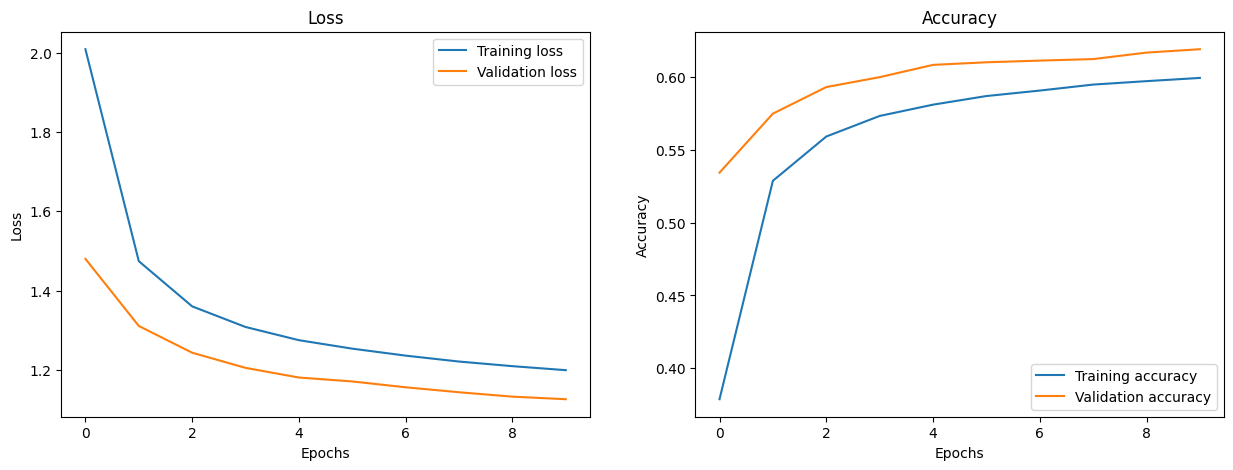

In [125]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='Training loss')
    ax1.plot(history.history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')

    ax2.plot(history.history['accuracy'], label='Training accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy')

    plt.show()

plot_history(history)

Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

In [142]:
generated_molecules = []
filtered_smiles = [smiles for smiles in df['smiles'] if 10 <= len(smiles) <= 50]
filtered_smiles = pd.Series(filtered_smiles).sample(100)
idx = 0

while idx < 100:
    # Randomly choose a seed start from the list of seeds with length between seq_length and len(smile) - 1
    seed_start = filtered_smiles.iloc[idx][:np.random.randint(seq_length, len(filtered_smiles.iloc[idx]) - 1)]
    generated_molecule = make_prediction(seed_start, model, char_to_int, int_to_char, seq_length, max_length=max_len)
    
    # Filter out molecules that don't meet the atom count criteria
    if 10 <= len(generated_molecule) <= 50:
        generated_molecules.append(generated_molecule)
        
    idx += 1

# Print the list of generated molecules
for i, molecule in enumerate(generated_molecules, start=1):
    print(f"Molecule {i}:\n{molecule}\n")

Molecule 1:
CC[C@H](CO)cc1


Molecule 2:
CC[C@@H](C)C)cc1


Molecule 3:
C[C@@H](Cc1cccs1)N(C)C)cc1


Molecule 4:
Cc1ccc(N2C(=O)N(CCS(C)(=O)=O)C(=O)[C@H](C)C)cc1


Molecule 5:
NC(N)=[NH+]Cc1ccc(Cl)cc1


Molecule 6:
COC(=O)c1sc(-c2ccc([N+](=O)[O-])cc2)cc1


Molecule 7:
COc1ccc(Cl)cc1


Molecule 8:
O=C(Nc1nc(C)c1ccc(Cl)cc1


Molecule 9:
Cc1ccc(-c2cccc(N)c2)cc1


Molecule 10:
COc1ccc(Cl)cc1


Molecule 11:
CCCCNC(=O)c1onc(C)c1ccc(Cl)cc1


Molecule 12:
COc1ccc([C@@]2(O)CCCS[C@H]2C)c(C)c1ccc(Cl)cc1


Molecule 13:
COc1ccc(C(=O)[O-])cc1-c1ccc(Cl)cc1


Molecule 14:
COc1ccccc1-c1ccc(Cl)cc1


Molecule 15:
O=C(NC(=S)Nc1ccc(NC(=O)c2ccccc2)cc1)c1ccc(Cl)cc1


Molecule 16:
CC/[NH+]=C(\N)cc1


Molecule 17:
CCN[C@@]1(C#N)CCC[C@H]([NH+](C)C)cc1


Molecule 18:
O=C(NC1=NCCS1)c1ccc(Cl)cc1


Molecule 19:
C[C@@H](C)C)cc1


Molecule 20:
CCc1nn(C)cc1CNC(=O)[C@@H](C)C)cc1


Molecule 21:
COc1cc(NC(=O)NCCc2c(C)nn(C)c2C)cc(Cl)cc1


Molecule 22:
Cc1cc(N(C)C)cc1


Molecule 23:
COc1cc([C@@H](C)C)cc1


Molecule 24:
C[C@

With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

In [143]:
from rdkit import Chem
from rdkit.Chem import QED

# Define a function to compute QED for a given SMILES string
def compute_qed(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        qed_score = QED.qed(mol)
        return qed_score
    else:
        return None

# Compute QED for each molecule in the filtered_smiles list
qed_scores = []
for smiles in filtered_smiles:
    qed_score = compute_qed(smiles)
    if qed_score is not None:
        qed_scores.append(qed_score)

# Print QED scores for each molecule
for i, qed_score in enumerate(qed_scores, start=1):
    print(f"Molecule {i}: QED Score = {qed_score:.4f}")


Molecule 1: QED Score = 0.8853
Molecule 2: QED Score = 0.5538
Molecule 3: QED Score = 0.8964
Molecule 4: QED Score = 0.7438
Molecule 5: QED Score = 0.8881
Molecule 6: QED Score = 0.7831
Molecule 7: QED Score = 0.8189
Molecule 8: QED Score = 0.7733
Molecule 9: QED Score = 0.3998
Molecule 10: QED Score = 0.7050
Molecule 11: QED Score = 0.7756
Molecule 12: QED Score = 0.5287
Molecule 13: QED Score = 0.8808
Molecule 14: QED Score = 0.9010
Molecule 15: QED Score = 0.8342
Molecule 16: QED Score = 0.6935
Molecule 17: QED Score = 0.8301
Molecule 18: QED Score = 0.6464
Molecule 19: QED Score = 0.7852
Molecule 20: QED Score = 0.8767
Molecule 21: QED Score = 0.8647
Molecule 22: QED Score = 0.8431
Molecule 23: QED Score = 0.8495
Molecule 24: QED Score = 0.5452
Molecule 25: QED Score = 0.5824
Molecule 26: QED Score = 0.4947
Molecule 27: QED Score = 0.6842
Molecule 28: QED Score = 0.4680
Molecule 29: QED Score = 0.8610
Molecule 30: QED Score = 0.7829
Molecule 31: QED Score = 0.8705
Molecule 32: QED 

Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

In [144]:
# Compute QED for each molecule in the generated_molecules list
qed_scores = []
for smiles in generated_molecules:
    qed_score = compute_qed(smiles)
    if qed_score is not None:
        qed_scores.append(qed_score)

# Print QED scores for each molecule
for i, qed_score in enumerate(qed_scores, start=1):
    print(f"Molecule {i}: QED Score = {qed_score:.4f}")

Molecule 1: QED Score = 0.4161
Molecule 2: QED Score = 0.4844
Molecule 3: QED Score = 0.5851
Molecule 4: QED Score = 0.6747
Molecule 5: QED Score = 0.5851
Molecule 6: QED Score = 0.8523
Molecule 7: QED Score = 0.7401
Molecule 8: QED Score = 0.5452
Molecule 9: QED Score = 0.6464
Molecule 10: QED Score = 0.8176
Molecule 11: QED Score = 0.5851
Molecule 12: QED Score = 0.7207
Molecule 13: QED Score = 0.6527
Molecule 14: QED Score = 0.9190
Molecule 15: QED Score = 0.5851
Molecule 16: QED Score = 0.7962
Molecule 17: QED Score = 0.7209
Molecule 18: QED Score = 0.9207


[01:14:31] SMILES Parse Error: unclosed ring for input: 'CC[C@H](CO)cc1
'
[01:14:31] SMILES Parse Error: extra close parentheses while parsing: CC[C@@H](C)C)cc1

[01:14:31] SMILES Parse Error: Failed parsing SMILES 'CC[C@@H](C)C)cc1
' for input: 'CC[C@@H](C)C)cc1
'
[01:14:31] SMILES Parse Error: extra close parentheses while parsing: C[C@@H](Cc1cccs1)N(C)C)cc1

[01:14:31] SMILES Parse Error: Failed parsing SMILES 'C[C@@H](Cc1cccs1)N(C)C)cc1
' for input: 'C[C@@H](Cc1cccs1)N(C)C)cc1
'
[01:14:31] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(N2C(=O)N(CCS(C)(=O)=O)C(=O)[C@H](C)C)cc1
'
[01:14:31] SMILES Parse Error: extra open parentheses for input: 'O=C(Nc1nc(C)c1ccc(Cl)cc1
'
[01:14:31] SMILES Parse Error: unclosed ring for input: 'CCCCNC(=O)c1onc(C)c1ccc(Cl)cc1
'
[01:14:31] SMILES Parse Error: unclosed ring for input: 'COc1ccc([C@@]2(O)CCCS[C@H]2C)c(C)c1ccc(Cl)cc1
'
[01:14:31] SMILES Parse Error: unclosed ring for input: 'CC/[NH+]=C(\N)cc1
'
[01:14:31] SMILES Parse Error: extra clo

Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better